# Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_curve
import json
import numpy as np
import sklearn.preprocessing as pre
# from fetch_data import get, get_KS
import tensorflow.keras as keras
from pyts.image import GramianAngularField as GAF
from pyts.image import MarkovTransitionField as MTF
from sklearn.metrics import auc, roc_curve
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import pickle
# package for GAF and MTF
%matplotlib inline

data_dir = '../../data/processed/'    

In [2]:
def get(train_size, val_size, test_size):
    '''
    remember to adjust your file path
    read the data for use
    '''
    data_dir = '../../data/processed/'
    with open(data_dir+'label.json') as f:
        label = json.load(f)
    with open(data_dir+'non_sequential_features.json') as f:
        non_sequential_features = json.load(f)
    with open(data_dir+'features_sequential_embedded.json') as f:
        sequential_features = json.load(f)

    # with open(data_dir+'features_sequential_embedded.txt', "rb") as fp:   #Unpickling
    #     feature1 = pickle.load(fp)

    label_size = len(label)
    train_size = int(train_size*label_size)
    val_size = int(val_size*label_size)
    test_size = int(test_size*label_size)
    
#     feature1 = np.array([sequential_features[key]
#                          for key in sequential_features.keys()])
    feature1 = np.array(feature1)
    feature2 = np.array([non_sequential_features[key]
                         for key in non_sequential_features.keys()])
    label = np.array([label[key] for key in label.keys()])
    feature1_benign = feature1[label == 1]
    feature2_benign = feature2[label == 1]
    label_benign = label[label == 1]

    idx = np.arange(len(label))
    np.random.shuffle(idx)

    idx_train = idx[:train_size]
    idx_val = idx[train_size:train_size+val_size]
    idx_test = idx[train_size+val_size:train_size+val_size+test_size]

    train_seq, val_seq, test_seq = feature1[idx_train], feature1[idx_val], feature1[idx_test]
    train_non, val_non, test_non = feature2[idx_train], feature2[idx_val], feature2[idx_test]
    train_Y, val_Y, test_Y = label[idx_train], label[idx_val], label[idx_test]

    return (train_seq, train_non, train_Y), (val_seq, val_non, val_Y), (test_seq, test_non, test_Y)

def get_KS(y_prob,y_true):
    ''' 
    y_prob: the predict_proba from the model
    y_true: the true label of Y
    this one calculates the KS value for a model
    return the best threshold, maximum ks
    '''
    from sklearn.metrics import roc_curve
    fpr,tpr,threshold=roc_curve(y_true,y_prob)
    ks=(tpr-fpr)
    max_=np.argmax(ks)
    
    return threshold[max_],np.max(ks)

In [4]:
data_dir = '../../data/processed/'
with open(data_dir+'label.json') as f:
    label = json.load(f)
with open(data_dir+'non_sequential_features.json') as f:
    non_sequential_features = json.load(f)
with open(data_dir+'padded_sequential_features.json') as f:
    sequential_features = json.load(f)

# with open(data_dir+'features_sequential_embedded.txt', "rb") as fp:   #Unpickling
#     feature1 = pickle.load(fp)

label_size = len(label)
train_size = int(train_size*label_size)
val_size = int(val_size*label_size)
test_size = int(test_size*label_size)

#     feature1 = np.array([sequential_features[key]
#                          for key in sequential_features.keys()])
feature1 = np.array(feature1)
feature2 = np.array([non_sequential_features[key]
                     for key in non_sequential_features.keys()])
label = np.array([label[key] for key in label.keys()])

NameError: name 'train_size' is not defined

In [2]:
# read the data and split into train, validation and test

train, val, test = get(train_size=0.85, val_size=0.05, test_size=0.1)

In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
     print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
     print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


# CNN+LSTM

In [34]:
#  the train set contains data for sequence, non_sequential data and labels
train_seq, train_non, train_Y = train
train_seq.shape, train_non.shape, train_Y .shape

((127434, 20, 50), (127434, 14), (127434,))

In [35]:
def non_onehot(data, size1):
    '''
    data: the data you need to use
    size1: any number 
    in this trial, we only use the Onehotted data for training, 
    this function gets the labelized data out
    '''
    part1 = (data[:, :, 0]).copy()

    part2 = (data[:, :, size1:]).copy()

#     part1=np.argmax(part1,axis=-1)
    part1 = part1[:, :, np.newaxis]

    return data[:, :, 1:]

In [36]:
t = pre.OneHotEncoder()
train_Y = (t.fit_transform(train_Y[:, np.newaxis])).todense()
# we will use binary_crossentropy loss in the following model, thus we will need to
# one-hot the Y label.

In [37]:
train_seq.shape, train_non.shape, train_Y.shape

((127434, 20, 50), (127434, 14), (127434, 2))

In [38]:
val_seq, val_non, val_Y = val
val_Y = (t.fit_transform(val_Y[:, np.newaxis])).todense()
val_seq.shape, val_non.shape, val_Y.shape

((7496, 20, 50), (7496, 14), (7496, 2))

In [39]:
class CNN_LSTM:
    def __init__(self, data, data_non_seq, features, bins_list, size, strategy, label):
        '''
        data: training data, sequential data
        data_non_seq: training data, non_sequential data
        bins_list: the bins you want for different features when generating MTF
        features: the number of features you feed into the model
        size: fig_size for MTF and GAF ( not apply in this project since we only use LSTM)
        strategy: the strategy for generating MTF, usually use normal
        label: the training label, Y
        '''
        self.size = size
        self.strategy = strategy
        self.true_features = features
        self.bins_list = bins_list
        self.label = label

        self.auc_list = list()

        tp_shape = data_non_seq.shape
        self.non_seq_shape = (tp_shape[1],)
#         non_seq_shape: for later use in the model for non_sequential data

        testing = self.transform_used(
            100, data, data_non_seq, label=self.label)
        self.img_shape = (1, 2, 3)
#         not useful in this project


#         creating models and compile for training
        self.CNN = self.CNN_()
        self.LSTM = self.LSTM_()
        self.non_sequential_NN = self.non_sequential_NN_()
        self.complete_model = self.whole_model()

        optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        self.CNN.trainable = True
        self.LSTM.trainable = True
        self.non_sequential_NN.trainable = True
        self.complete_model.compile(
            loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

#         metrics : for storing the models. only when the model has higher KS and higher AUC in validation
#         dataset, will we store the model for later use
        self.metrics = [0, 0, 0, 0, 0]

    def data_mtf(self, X, bins):
        mtf = MTF(image_size=self.size, n_bins=bins, strategy=self.strategy)
        mtf.fit(X)
        return mtf

    def data_gaf(self, X):
        gaf = GAF(image_size=self.size)
        gaf.fit(X)
        return gaf

    def transform_used(self, batch_size, data_used, data_non, label,
                       random_or_not=True, train=True):
        '''
        data_used: sequentila data 
        data_non: non_sequential data
        label: label for training
        random_or_not:False, not random, True, will shuffle it. 
        this will be important when you are not training data. Since we will sometimes use this 
        function generating data for prediction. And the label will then can be randomly assigned
        '''

        X_train = data_used

#         for epoch in range(epochs):
        whole = len(X_train)//batch_size+(len(X_train) % batch_size != 0)
        total_loss = 0

        idx = np.arange(len(data_used))
        if random_or_not:
            np.random.shuffle(idx)
        else:
            pass

        for step in range(whole):
            imgs = X_train[idx[step*batch_size:(step+1)*batch_size]]
#                 get the whole transformed_data

            non_seq_data = data_non[idx[step*batch_size:(step+1)*batch_size]]
            lstm_data = X_train[idx[step*batch_size:(step+1)*batch_size]]
            return_label = label[idx[step*batch_size:(step+1)*batch_size]]

            yield(non_seq_data, non_seq_data, lstm_data, return_label)

    def CNN_(self):
        '''
        keras model. CNN
        '''
        dropout = 0.5
        model = keras.Sequential()
        model.add(keras.layers.Conv2D(filters=64, kernel_size=4, strides=2, padding='same', activation='relu',
                                      input_shape=self.img_shape))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))
        model.add(keras.layers.AveragePooling2D(
            pool_size=4, strides=(2, 2), padding='same'))

        model.add(keras.layers.Conv2D(filters=16, kernel_size=2,
                                      strides=2, padding='same', activation='relu'))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))
        model.add(keras.layers.AveragePooling2D(
            pool_size=4, strides=(2, 2), padding='same'))

        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(64, activation='relu'))

        img = keras.Input(shape=self.img_shape)
        val = model(img)

        model.summary()
        return keras.Model(img, val)

    def LSTM_(self):
        '''
        LSTM keras model, try to handel original data     
        adding 1-D convolution first, will probably catch the 
        '''
        timesteps = 20
        n_features = self.true_features
        model = keras.Sequential()
        model.add(keras.layers.Conv1D(filters=64, kernel_size=4, padding='same',
                                      activation='relu', strides=1, input_shape=(timesteps, n_features)))

        model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, activation="tanh",
                                                               return_sequences=True)))
#         model.add(Bidirectional(keras.layers.LSTM(128, activation="tanh", return_sequences=True)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("tanh"))
        model.add(keras.layers.Dropout(0.5))

        model.add(keras.layers.Bidirectional(keras.layers.LSTM(
            32, activation="tanh", return_sequences=False)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("tanh"))
        model.add(keras.layers.Dropout(0.5))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(units=64, activation="relu"))

        inp = keras.Input(shape=(timesteps, n_features))
        out = model(inp)
        model.summary()
        return keras.Model(inp, out)

    def non_sequential_NN_(self):
        '''
        Neural network for NN
        '''
        dropout = 0.5
        n_features = self.non_seq_shape
        model = keras.Sequential()
        model.add(keras.layers.Dense(
            128, activation="relu", input_shape=n_features))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))

        model.add(keras.layers.Dense(64, activation="relu"))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))

#         model.add(keras.layers.Dense(32,activation="relu"))

        inp = keras.Input(shape=n_features)
        out = model(inp)
        model.summary()
        return keras.Model(inp, out)

    def whole_model(self):
        '''
        putting all models together

        this model combine all the models together, One can easily add more or delete some model 
        out from here. 

        when you change the input or output model here, remember to correpondingly change the 
        input for function : transformed_used, model_predict and training. 
        only the input will need to modified. 

        '''
        dropout = 0.5
#         seq_inp=keras.Input(shape=self.img_shape)
        non_inp = keras.Input(shape=self.non_seq_shape)
        LSTM_inp = keras.Input(shape=(20, self.true_features))

#         seq=self.CNN(seq_inp)
        non_seq = self.non_sequential_NN(non_inp)
        rnn = self.LSTM(LSTM_inp)

#         model=keras.Sequential()
        concat_ = keras.layers.concatenate([non_seq, rnn])
#         concat_=non_seq
        flat = keras.layers.Flatten()(concat_)
        act1 = keras.layers.Dense(128, activation="relu")(flat)
        norm1 = keras.layers.BatchNormalization()(act1)
        drop1 = keras.layers.Dropout(dropout)(norm1)

#         act2=keras.layers.Dense(64,activation="relu")(drop1)
#         drop2=keras.layers.Dropout(dropout)(act2)

        act3 = keras.layers.Dense(32, activation="relu")(drop1)
        norm3 = keras.layers.BatchNormalization()(act3)
        drop4 = keras.layers.Dropout(dropout)(norm3)

        out = keras.layers.Dense(2, activation="softmax")(drop4)

        model = keras.Model(inputs=[non_inp, LSTM_inp], outputs=out)
        model.summary()
        return model

    def training(self, epochs, batch_size, show_epoch, data, data_non, label,
                 val_seq, val_non, val_Y, path=None):
        '''
        for training the data;
        epochs: 
        batch_size: when the data for a single user is big, please use a small batch
        show_epoch
        data: sequential data
        data_non: non_sequential data
        label
        val_seq: sequential data in validation set
        val_non
        val_Y: Y, label in validation set
        '''
        data_used = data
        for epoch in range(epochs):
            gener = self.transform_used(batch_size, data, data_non, label)
            whole = len(data_used)//batch_size + \
                (len(data_used) % batch_size != 0)
            total_loss = 0
            mean_accuracy = 0

            for step in range(whole):
                imgs, non_seq_data, lstm_data, label_batch = next(gener)
                loss = self.complete_model.fit(
                    [non_seq_data, lstm_data], label_batch, batch_size=batch_size, epochs=1, verbose=0)
            if epoch % show_epoch == 0:
                predict_prob, predict = self.model_predict(model=self.complete_model, data_seq=val_seq, data_non=val_non,
                                                           batch_size=100)

                val_acc = np.mean(predict == val_Y[:, 1])
                _, val_KS = get_KS(predict_prob[:, 1], val_Y[:, 1])
                fpr, tpr, threshold = roc_curve(
                    val_Y[:, 1], predict_prob[:, 1])
                val_auc = auc(fpr, tpr)
                self.saver(name="../../data/models/binary_classification_model/"+"LSTM1FC1_show1_epoch"+str(epoch)+".h5", model=self.complete_model,
                           metrics=[val_KS, val_auc])
                self.auc_list.append(val_auc)
                print("training on epoch: {}, validation accuracy is {}".format(
                    epoch, val_acc))
                print("training on epoch: {}, validation KS is {}".format(
                    epoch, val_KS))
                print("training on epoch: {}, validation AUC is {}".format(
                    epoch, val_auc))
                print("balance_status of validation set have {} of ones in val".format(
                    np.sum(val_Y[:, 1])/len(val_Y)))

                fpr, tpr, threshold = roc_curve(
                    val_Y[:, 1], predict_prob[:, 1])
                plt.title('ROC')
                plt.plot(fpr, tpr, 'b')
                plt.legend(loc='lower right')
                plt.plot([0, 1], [0, 1], 'r--')
                plt.xlim([0, 1])
                plt.ylim([0, 1])
                plt.ylabel('True Positive Rate')
                plt.xlabel('False Positive Rate')
                plt.show()


#                 a=self.sample_images(X=X,epoch=epoch)
                print(
                    "------------generate form-------------------------------------------")
                print(
                    "--------------------------------------------------------------------")

    def saver(self, name, model, metrics=None):
        '''
        name: path you save the model
        metrics: the baseline metrics you need to compare. when reach a model with nicer metrics, 
        will then save the model to the path
        '''
        if metrics == None:
            model.save(name)
        else:
            if (metrics[0] > self.metrics[0]) and (metrics[1] > self.metrics[1]):
                model.save(name)
                self.metrics = metrics
                print(
                    "-----------------------saving models------------------------------")
            else:
                pass

    def model_predict(self, model, data_seq, data_non, batch_size):
        '''
        return prediction for using batch_size
        '''
        fake_label = np.arange(len(data_non))
        k = self.transform_used(batch_size, data_used=data_seq, data_non=data_non, label=fake_label,
                                random_or_not=False, train=False)
        store = []
        for i in range(len(data_seq)//batch_size+(len(data_seq) % batch_size != 0)):

            test_dataset = next(k)

#             d0=test_dataset[0]
            d1 = test_dataset[1]
            d2 = test_dataset[2]
#                     pay attention to the d1 d2 here. you need to adjust it
            test_predict_prob = model.predict([d1, d2])
            store.append(test_predict_prob)
        store = np.concatenate(store)
        prob = store
        prediction = np.argmax(prob, axis=-1)
        return prob, prediction

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 1, 1, 64)          3136      
_________________________________________________________________
batch_normalization_80 (Batc (None, 1, 1, 64)          256       
_________________________________________________________________
re_lu_40 (ReLU)              (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 1, 1, 64)          0         
_________________________________________________________________
average_pooling2d_20 (Averag (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 1, 1, 16)          4112      
_________________________________________________________________
batch_normalization_81 (Batc (None, 1, 1, 16)        

No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 0, validation accuracy is 0.23832212469916364
training on epoch: 0, validation KS is 0.03507439749778524
training on epoch: 0, validation AUC is 0.5142375351682723
balance_status of validation set have 0.06870330843116329 of ones in val


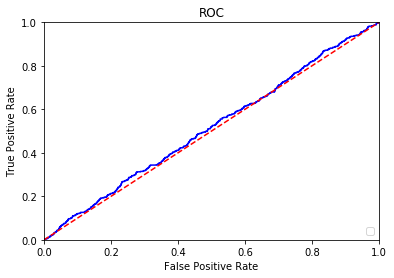

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 20, validation accuracy is 0.9312966915688368
training on epoch: 20, validation KS is 0.019798815926168535
training on epoch: 20, validation AUC is 0.49066676123681063
balance_status of validation set have 0.06870330843116329 of ones in val


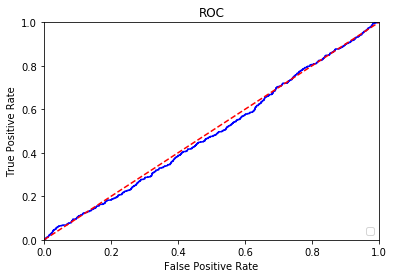

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 40, validation accuracy is 0.9312966915688368
training on epoch: 40, validation KS is 0.11381155229937567
training on epoch: 40, validation AUC is 0.5625977862241897
balance_status of validation set have 0.06870330843116329 of ones in val


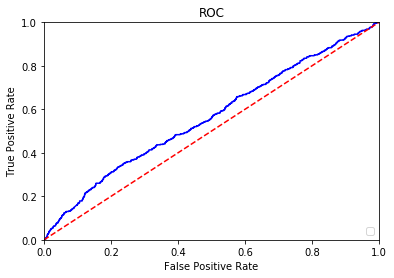

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 60, validation accuracy is 0.9312966915688368
training on epoch: 60, validation KS is 0.13429488917908944
training on epoch: 60, validation AUC is 0.5773825765635714
balance_status of validation set have 0.06870330843116329 of ones in val


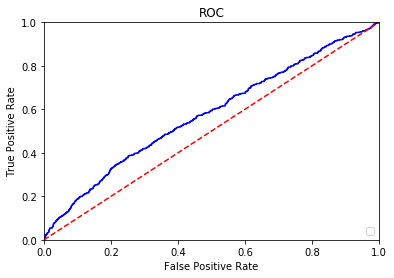

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 80, validation accuracy is 0.9312966915688368
training on epoch: 80, validation KS is 0.130520427846457
training on epoch: 80, validation AUC is 0.5756359494494766
balance_status of validation set have 0.06870330843116329 of ones in val


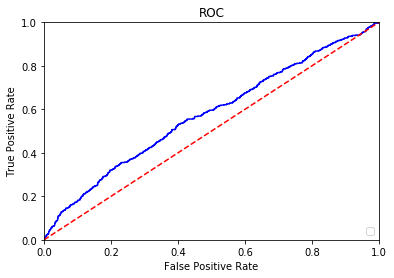

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 100, validation accuracy is 0.9312966915688368
training on epoch: 100, validation KS is 0.13970513585418398
training on epoch: 100, validation AUC is 0.5775547498550155
balance_status of validation set have 0.06870330843116329 of ones in val


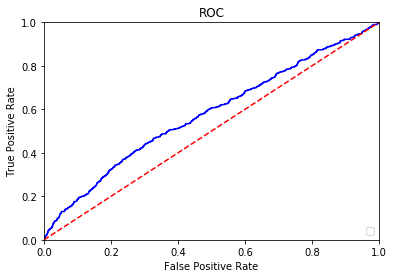

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 120, validation accuracy is 0.9312966915688368
training on epoch: 120, validation KS is 0.14250774988422107
training on epoch: 120, validation AUC is 0.577848612669896
balance_status of validation set have 0.06870330843116329 of ones in val


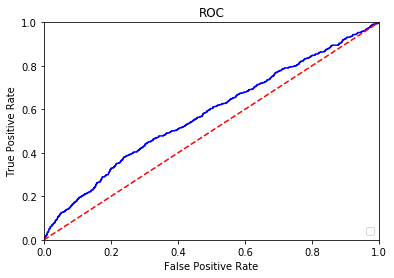

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 140, validation accuracy is 0.9312966915688368
training on epoch: 140, validation KS is 0.14223739053158158
training on epoch: 140, validation AUC is 0.578476947832049
balance_status of validation set have 0.06870330843116329 of ones in val


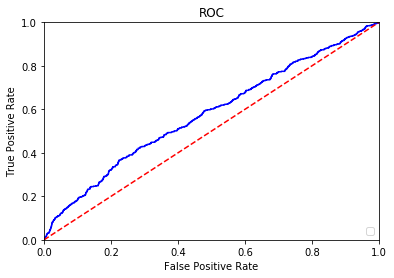

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 160, validation accuracy is 0.9312966915688368
training on epoch: 160, validation KS is 0.12842180509371487
training on epoch: 160, validation AUC is 0.574865063702727
balance_status of validation set have 0.06870330843116329 of ones in val


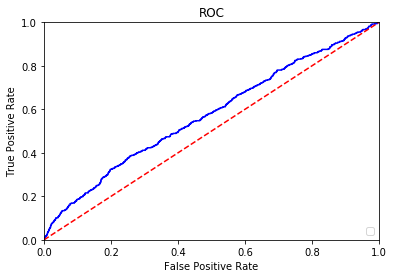

------------generate form-------------------------------------------
--------------------------------------------------------------------


In [ ]:
 with tf.device('/device:GPU:0'):
    # CNN is not useful here
    bins_list = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 10, 10, 10, 10, 10]
    data = train_seq
    data_non_seq = train_non
    features = 50
    size = 20
    strategy = "uniform"
    label = train_Y
    test_model = CNN_LSTM(data=data, data_non_seq=data_non_seq, features=features, bins_list=bins_list,
                      size=size, strategy=strategy, label=train_Y)
    test_model.training(epochs=1000, batch_size=1000, show_epoch=20, data=data,
                    data_non=data_non_seq, label=train_Y, val_seq=val_seq, val_non=val_non, val_Y=val_Y)
# testing the data

In [64]:
test_seq, test_non, test_Y = test
# test_seq = non_onehot(test_seq, 14)
test_Y = (t.fit_transform(test_Y[:, np.newaxis])).todense()
fpr, tpr, threshold = roc_curve(test_Y[:, 1], test_predict_prob[:, 1])
test_auc = auc(fpr, tpr)
test_auc

0.576807844186477

In [53]:
# YY_prob.shape

In [54]:
# YY_prob=test_model.non_sequential_NN.predict(test_non)
# np.sum(YY_prob,axis=-1)

In [55]:
# np.sum(YY_prob)

In [56]:
73338.695

73338.695

In [57]:
# YL_prob=test_model.LSTM.predict(test_seq)
# np.sum(YL_prob,axis=-1)

In [58]:
# np.sum(YL_prob)

In [59]:
# test on the test dataset
k = test_model.transform_used(500, data_used=test_seq, data_non=test_non, label=train_Y,
                              random_or_not=False, train=False)
store = []
for i in range(len(test_seq)//500+(len(test_seq) % 500 != 0)):
    test_dataset = next(k)
    d1 = test_dataset[1]
    d2 = test_dataset[2]
    test_predict_prob = test_model.complete_model.predict([d1, d2])
    store.append(test_predict_prob)
store = np.concatenate(store, axis=0)
test_predict_prob = store
test_predict = np.argmax(test_predict_prob, axis=-1)
acc = np.mean(test_predict == test_Y[:, 1])
test_ks = get_KS(test_predict_prob[:, 1], test_Y[:, 1])
acc, test_ks

(0.9310965848452508, (0.05988114, 0.12243545213000012))

In [61]:
fpr, tpr, threshold = roc_curve(test_Y[:, 1], test_predict_prob[:, 1])
test_auc = auc(fpr, tpr)
test_auc

0.576807844186477

No handles with labels found to put in legend.


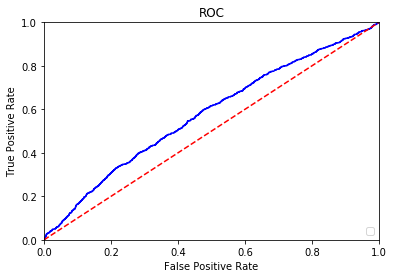

In [62]:
fpr, tpr, threshold = roc_curve(test_Y[:,1],test_predict_prob[:,1])                
plt.title('ROC')
plt.plot(fpr, tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [1]:
plt.plot(test_model.auc_list)
plt.show()

NameError: name 'plt' is not defined